<div align="center">
    <font color="0F5298" size="7">
        Deep Learning <br>
    </font>
    <font color="2565AE" size="5">
        CE Department <br>
        Spring 2024 - Prof. Soleymani Baghshah <br>
    </font>
    <font color="3C99D" size="5">
        HW2 Practical <br>
    </font>
    <font color="696880" size="5">
        30 Points
    </font>
</div>


In [1]:
FULLNAME = 'Nikan Vasei'
STD_ID = '400105303'

# Q3. License Plate Detection and Recognition (30 points)

## Introduction

In this assignment, we will build a two-stage license plate recognition system:

1. First stage: Detect license plates in an image (license plate detection / LPD)
2. Second stage: Recognize characters within the detected license plate (license plate recognition / LPR)

This approach is not explicitly an OCR (Optical Character Recognition), but it has some similarities with important differences. Unlike general OCR which often relies on sequence models (like RNNs or Transformers) to capture language context, license plates have a fixed format with predictable structure. This allows us to use multi-class classification or object detection models for it - first to locate plates, then to locate and classify individual characters.

## Background on YOLO (You Only Look Once)

### Evolution of Object Detection

Object detection has evolved significantly over the years:
- **Two-stage detectors** (like R-CNN family): First propose regions, then classify them
- **Single-stage detectors** (like YOLO and SSD): Predict bounding boxes and classes in a single forward pass

YOLO revolutionized object detection by framing it as a regression problem rather than a classification problem. Instead of generating region proposals and then classifying each region (a slow, two-stage process), YOLO divides the image into a grid and predicts bounding boxes and class probabilities directly in a single forward pass.

### YOLO Architecture

![YOLO Architecture](https://velog.velcdn.com/images/hunniee_j/post/cbd3888c-8b75-4325-988f-eadaded84232/image.JPG)

The basic YOLO approach:

1. **Grid Division**: Divide the image into an S×S grid
2. **Bounding Box Prediction**: Each grid cell predicts B bounding boxes, each with 5 parameters (x, y, w, h, confidence)
3. **Class Prediction**: Each grid cell also predicts class probabilities
4. **Non-Maximum Suppression**: Remove overlapping boxes with lower confidence scores

for a brief explanation of Object detection from RCNN to yolo version8 visit this [link](https://youtube.com/playlist?list=PL8VDJoEXIjppNvOzocFbRciZBrtSMi81v&si=qIh3VagQOzgWZ7Go)

the latest version of yolo is YOLO 12 and [here](https://docs.ultralytics.com/models/yolo12/) is Ultralytics documentation about it (all models of yolo family available in ultralytics has accessible documentation  [here](https://docs.ultralytics.com/models/) too.)


## Ultralytics Framework

Ultralytics is a Python library that makes it easy to train, test, and deploy YOLO models. Key features:

- **Easy to use API**: Simple Python API for training, validation, and inference
- **Pre-trained models**: Various pre-trained models of different sizes (nano to extra large)
- **Export options**: Export to various formats (ONNX, TFLite, CoreML, etc.)
- **Multi-task learning**: Support for object detection, segmentation, and pose estimation



## Assignment Tasks

In this assignment, you will:

1. Train a YOLO model for license plate detection on LPD dataset
2. Train a CNN model for license plate recognition within LPR license plates (7 digit + 1 letter classificaiton task)
3. Create an end-to-end pipeline that connects step 1 with 2
4. Evaluate the performance of your system on the test data


The dataset are available in [this](https://drive.google.com/drive/folders/1StRhbI28MaoiuXqA2rG5vGqKG5K2bMW6?usp=sharing) drive folder. let's dive into it!



In [2]:
#Necessary installations

%pip install -q ultralytics
%pip install -q matplotlib opencv-python pyyaml

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
#imports

import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from ultralytics import YOLO
import random
import pandas as pd
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
from IPython.display import display
import pandas as pd
import torch.utils.data as data
import torch
from tqdm import tqdm
import torch.optim as optim
import torch
import torch.nn as nn
from torchvision import models
import cv2
import shutil
import copy
import numpy as np


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
import gdown

lpd_file_id = "1mJ5LbRDhUU7jhu1rbq0_RMf0Bh0gBOFf"
lpr_file_id = "1NU730hPpeVsH4zUDraxQwn0xT2he3XB_"

url = f"https://drive.google.com/uc?export=download&id={lpd_file_id}"
gdown.download(url, output="LPD", quiet=False)

url = f"https://drive.google.com/uc?export=download&id={lpr_file_id}"
gdown.download(url, output="LPR", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1mJ5LbRDhUU7jhu1rbq0_RMf0Bh0gBOFf
From (redirected): https://drive.google.com/uc?export=download&id=1mJ5LbRDhUU7jhu1rbq0_RMf0Bh0gBOFf&confirm=t&uuid=75d7effa-0f19-4650-8ac0-f7913733b3e5
To: /kaggle/working/LPD
100%|██████████| 3.76G/3.76G [00:38<00:00, 97.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1NU730hPpeVsH4zUDraxQwn0xT2he3XB_
From (redirected): https://drive.google.com/uc?export=download&id=1NU730hPpeVsH4zUDraxQwn0xT2he3XB_&confirm=t&uuid=efd993c8-e5e3-4dd9-a24a-aa3715aaad9b
To: /kaggle/working/LPR
100%|██████████| 256M/256M [00:01<00:00, 191MB/s]  


'LPR'

In [6]:
!unzip LPD -d IR-LPD

Archive:  LPD
   creating: IR-LPD/images/
  inflating: IR-LPD/images/000001.jpg  
  inflating: IR-LPD/images/000002.jpg  
  inflating: IR-LPD/images/000003.jpg  
  inflating: IR-LPD/images/000004.jpg  
  inflating: IR-LPD/images/000005.jpg  
  inflating: IR-LPD/images/000006.jpg  
  inflating: IR-LPD/images/000007.jpg  
  inflating: IR-LPD/images/000008.jpg  
  inflating: IR-LPD/images/000009.jpg  
  inflating: IR-LPD/images/000010.jpg  
  inflating: IR-LPD/images/000011.jpg  
  inflating: IR-LPD/images/000012.jpg  
  inflating: IR-LPD/images/000013.jpg  
  inflating: IR-LPD/images/000014.jpg  
  inflating: IR-LPD/images/000015.jpg  
  inflating: IR-LPD/images/000016.jpg  
  inflating: IR-LPD/images/000017.jpg  
  inflating: IR-LPD/images/000018.jpg  
  inflating: IR-LPD/images/000019.jpg  
  inflating: IR-LPD/images/000020.jpg  
  inflating: IR-LPD/images/000021.jpg  
  inflating: IR-LPD/images/000022.jpg  
  inflating: IR-LPD/images/000023.jpg  
  inflating: IR-LPD/images/000024.jpg 

In [12]:
!unzip LPR -d IR-LPR

Archive:  LPR
  inflating: IR-LPR/valid_samples.csv  
   creating: IR-LPR/detections/
  inflating: IR-LPR/detections/1.jpg  
  inflating: IR-LPR/detections/10.jpg  
  inflating: IR-LPR/detections/100.jpg  
  inflating: IR-LPR/detections/1000.jpg  
  inflating: IR-LPR/detections/10000.jpg  
  inflating: IR-LPR/detections/10001.jpg  
  inflating: IR-LPR/detections/10002.jpg  
  inflating: IR-LPR/detections/10003.jpg  
  inflating: IR-LPR/detections/10004.jpg  
  inflating: IR-LPR/detections/10005.jpg  
  inflating: IR-LPR/detections/10006.jpg  
  inflating: IR-LPR/detections/10007.jpg  
  inflating: IR-LPR/detections/10008.jpg  
  inflating: IR-LPR/detections/10009.jpg  
  inflating: IR-LPR/detections/1001.jpg  
  inflating: IR-LPR/detections/10010.jpg  
  inflating: IR-LPR/detections/10011.jpg  
  inflating: IR-LPR/detections/10012.jpg  
  inflating: IR-LPR/detections/10013.jpg  
  inflating: IR-LPR/detections/10014.jpg  
  inflating: IR-LPR/detections/10015.jpg  
  inflating: IR-LPR/de

In [3]:
BASE_PATH = '/kaggle/working'

### 1. LPD - YOLO

In [4]:
LPD_RELATIVE_PATH = 'IR-LPD'
LPD_DIR = f'{BASE_PATH}/{LPD_RELATIVE_PATH}'

images_dir = os.path.join(LPD_DIR, 'images')
labels_dir = os.path.join(LPD_DIR, 'labels')

In [5]:
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

print(f"Dataset contains {len(image_files)} images and {len(label_files)} labels")


objects_count = 0
for label_file in [os.path.join(labels_dir, f) for f in label_files]:
    with open(label_file, 'r') as f:
        objects_count += len(f.readlines())

print(f"Total license plates in dataset: {objects_count}")
print(f"Average plates per image: {objects_count / max(1, len(image_files)):.2f}")

Dataset contains 6252 images and 6252 labels
Total license plates in dataset: 7257
Average plates per image: 1.16


<font color="orange">
1. What is the structure of YOLO's label files (`.txt`), and why are bounding box coordinates normalized?  
<br>2. How does the YAML configuration file in YOLO define a dataset, and what role does the `nc` (number of classes) parameter play?  
<br>3. Why does YOLO use a grid system for predictions, and how does it handle multiple objects in a single grid cell?  
</font>

<br>
<br>

<font color="green">
1. YOLO's label files are structured as (class_id x_center y_center width height). The class_id refers to the index of the class. x_center and y_center are the coordinates of the center of the box that the models predicts and also width and height are the shape of that box. Also we can see that the box coordinates are normalized, the reason for that is to make the model flexible when working with different image size (i.e., by using relative values we make the model more general)
<br>2. Again we have some key values that we need to define in order to define a dataset. Overall there are "train", "val", "nc" and "names" that need to be defined. "train" and "val" are paths to the train and validation sets. "nc" refers to the number of classes and is important because it's used to set the model's output layer's size when defining it. And at last we have "names" which is a list holding the names of different classes.
<br>3. As we saw above, YOLO uses the grid system in order to be able to detect objects in a single forward pass. By dividing the image into different cells and then detecting objects independently in each cell, allows YOLO to be able to achieve that goal. Also when encountering multiple objects in a single grid cell, YOLO first uses some confidence scores to prioritize between the boxes and then outputs multiple boxes corresponding to them.
</font>

In [16]:
# you must create a yaml file there is just one class object detection and you must split the dataset into two parts (80%-20% for train and val)
# the executed result of cell is belong to train = val = all data for better understanding about the YOLO results.

shuffled_image_files = copy.copy(image_files)
random.shuffle(shuffled_image_files)

train_files = shuffled_image_files[:int(0.8 * len(shuffled_image_files))]
val_files = shuffled_image_files[int(0.8 * len(shuffled_image_files)):]

train_images_dir = f'{BASE_PATH}/IR-LPD/train/images'
train_labels_dir = f'{BASE_PATH}/IR-LPD/train/labels'
val_images_dir = f'{BASE_PATH}/IR-LPD/val/images'
val_labels_dir = f'{BASE_PATH}/IR-LPD/val/labels'

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

for file_list, image_dir, label_dir in [(train_files, train_images_dir, train_labels_dir), (val_files, val_images_dir, val_labels_dir)]:
    for file in file_list:
        shutil.copy(os.path.join(images_dir, file), os.path.join(image_dir, file))

        label_file = file.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')
        shutil.copy(os.path.join(labels_dir, label_file), os.path.join(label_dir, label_file))

yaml_content = f"""
train: {BASE_PATH}/IR-LPD/train/images
val: {BASE_PATH}/IR-LPD/val/images/
nc: 1
names: ['license plate']
"""

with open(f'{BASE_PATH}/IR-LPD/data.yaml', 'w') as f:
    f.write(yaml_content)

YAML_PATH = os.path.join(LPD_DIR, 'data.yaml')

In [6]:
VERSION = '12'
MODEL_SIZE = 'n'  # Options: n, s, m, l, x
EPOCHS = 20
IMGSZ = 640
BATCH = 16
DEVICE = '0'

<font color="orange">
Compare the architectural and functional advancements in YOLO versions 8 through 12. Specifically:  

1. **YOLOv8**:  
   - What was the motivation behind adopting an anchor-free design, and how did this impact training complexity and performance?
     - This design made the detection process much simpler, because it didnt have to use predefined anchor boxes. As a result it made its training less complex while increasing its performance.  
   - How did the integration of CSPDarknet and PANet improve feature extraction and multi-scale detection compared to earlier versions?
     - So by using the CSPDarknet as the backbone, they made the feature exctraction capabilities much better and also by using PANet they improved multi-scaled detections. So overall by using both of them together, they managed to handle more complex objects while increasing accuracy.  

2. **YOLOv9 (Hypothetical/Unofficial)**:  
   - If YOLOv9 introduced dynamic label assignment, how does this differ from static assignment in YOLOv8, and what are the implications for model accuracy and convergence speed?
     - By using dynamic label assigment, the model was able to adaptively assign labels during its training time, and thus converge faster. This design also made the performance better in comparison to the static ones.
   - What role might lightweight model variants (e.g., YOLOv9n) play in edge-device deployment, and how were they optimized for resource-constrained environments?
     - As we know edge devices have limited resources (both computational and energy-related) and thus by using these lightweight model variants, we were able to make a good balance between performance and resource-energy efficiency. In other terms, they were able to reduce the complexity and computational requirements of the model to ensure efficient operation in critical places (resource related).

3. **YOLOv10**:  
   - How did hybrid loss functions (e.g., combining CIoU and focal loss) enhance the training process, and what challenges in object detection were they designed to address?
     - They were designed to address problems like bounding box regression accuracy or class imbalance. By using that combination, they were able to make the training more stable and increase detection performance. They could also detect some of the more complex objects using that combination.
   - What advancements in model pruning and quantization were introduced, and how did these techniques reduce model size without compromising accuracy?  
     - In this model they started eliminating non-maximum suppression (NMS) and also optimized various components of the model, which led to much lower computational overhead, while keeping the same performance as before.

4. **YOLOv11**:  
   - In what ways did self-calibrated convolutions improve feature extraction, and how do they compare to traditional convolutional layers in terms of computational efficiency and accuracy?  
     - By using the self-calibrated convolutions, they improved feature extraction by allowing the model to adjust its filters in a dynamic matter, enhancing both accuracy and computational efficiency compared to traditional convolutional layers.
   - How did the introduction of multi-task learning (e.g., joint object detection and segmentation) expand the capabilities of YOLOv11, and what new applications does this enable?  
     - This approach gave the model the ability to perform both object detection and segmentation tasks at the same time and made it a quite well-around choice for most of the computer vision problems.

5. **YOLOv12**:  
   - What benefits does the integration of transformer-based modules bring to YOLOv12, and how does this hybrid architecture balance the strengths of CNNs and transformers?  
     - By using the transformer-based modules, the model was able to capture global contextual information (in comparison to CNN's more local information) and thus combining them balances both of their strengths and also increases their accuracy while being fast.
   - How does uncertainty estimation in YOLOv12 improve the reliability of predictions, particularly in safety-critical applications like autonomous driving or medical imaging?  
    - Uncertainty estimation provides confidence measures for predictions and thus provides useful insights for the reliability of model's predictions. This is very useful in safety-critical systems (e.g., like the ones that need high reliabilities)
   - Discuss the role of domain adaptation techniques in YOLOv12 and how they address challenges like dataset bias or environmental variability.  
     - Domain adaptation techniques make the models more robust, in situations were we have dataset bias or a dynamic environment (e.g., it might be cloudy or sunny in two eactly similar images, thus the model should be able to adapt itself to different domain in order to be able to keep its performance high on all kinds of situations).

Based on these advancements, which version would you recommend for this aplication, and why?  

  - I recommend the YOLOv12 because of how powerful its tranformers modules could be and also because of the domain adaptations and augmentations that it has, it's a perfect choice for detection license plates in different and complex situation and environments. In simple terms, YOLOv12 has a much higher potential than most of them and thus would make a good choice here.
</font>

In [18]:
LPD_model = YOLO(f'yolo{VERSION}{MODEL_SIZE}.pt')

100%|██████████| 5.34M/5.34M [00:00<00:00, 75.1MB/s]


In [19]:
print(f"Starting YOLO{VERSION}{MODEL_SIZE} training for {EPOCHS} epochs...")

# TODO

results = LPD_model.train(data=YAML_PATH, epochs=EPOCHS, imgsz=IMGSZ, batch=BATCH,
                          device=DEVICE, pretrained=True, optimizer='auto')

print("Training complete! Model saved to model/LPD folder.")

Starting YOLO12n training for 20 epochs...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo12n.pt, data=/kaggle/working/IR-LPD/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fals

100%|██████████| 755k/755k [00:00<00:00, 18.4MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.7MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/IR-LPD/train/labels... 5001 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5001/5001 [00:04<00:00, 1186.14it/s]


train: New cache created: /kaggle/working/IR-LPD/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/IR-LPD/val/labels... 1251 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1251/1251 [00:01<00:00, 903.59it/s]

val: New cache created: /kaggle/working/IR-LPD/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.33G      1.245      1.732      1.048         21        640: 100%|██████████| 313/313 [01:22<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:11<00:00,  3.55it/s]


                   all       1251       1466      0.925      0.871      0.906      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.97G       1.19     0.9523      1.024         16        640: 100%|██████████| 313/313 [01:20<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.58it/s]

                   all       1251       1466      0.912      0.857      0.911      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.98G       1.18     0.8176      1.022         14        640: 100%|██████████| 313/313 [01:18<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.59it/s]

                   all       1251       1466      0.925      0.862      0.916      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.98G      1.123      0.734      1.003         18        640: 100%|██████████| 313/313 [01:18<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.65it/s]

                   all       1251       1466      0.927      0.851      0.902      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.98G      1.077     0.6866     0.9882         20        640: 100%|██████████| 313/313 [01:17<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:09<00:00,  4.42it/s]

                   all       1251       1466      0.924      0.888      0.927      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.98G      1.042     0.6526     0.9839         13        640: 100%|██████████| 313/313 [01:18<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.66it/s]

                   all       1251       1466      0.937      0.892      0.946      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.98G      1.016     0.6257     0.9718         19        640: 100%|██████████| 313/313 [01:18<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.73it/s]

                   all       1251       1466      0.944       0.89      0.948      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.98G     0.9941     0.6029     0.9599         17        640: 100%|██████████| 313/313 [01:18<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.48it/s]

                   all       1251       1466      0.945      0.879      0.934      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.98G     0.9583     0.5762       0.95         20        640: 100%|██████████| 313/313 [01:18<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]

                   all       1251       1466      0.933       0.89      0.945       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.98G     0.9633     0.5757     0.9518         16        640: 100%|██████████| 313/313 [01:18<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.65it/s]

                   all       1251       1466      0.932      0.917      0.958      0.697


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.98G     0.9271     0.5449     0.9499         10        640: 100%|██████████| 313/313 [01:19<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]

                   all       1251       1466      0.945      0.884      0.946      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.98G     0.9293     0.5418      0.944         10        640: 100%|██████████| 313/313 [01:18<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.47it/s]

                   all       1251       1466      0.938      0.902      0.943      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.98G     0.9069     0.5153     0.9481          9        640: 100%|██████████| 313/313 [01:17<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.66it/s]

                   all       1251       1466      0.934      0.907      0.949      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.98G     0.8869     0.5002      0.943          9        640: 100%|██████████| 313/313 [01:18<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.58it/s]

                   all       1251       1466      0.944      0.903      0.952      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.98G     0.8647     0.4856      0.929         10        640: 100%|██████████| 313/313 [01:18<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:09<00:00,  4.34it/s]

                   all       1251       1466      0.927      0.912      0.951       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.98G     0.8532     0.4709     0.9249         10        640: 100%|██████████| 313/313 [01:18<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.54it/s]

                   all       1251       1466      0.943      0.911      0.956      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.98G      0.834     0.4576     0.9224          9        640: 100%|██████████| 313/313 [01:18<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.60it/s]

                   all       1251       1466      0.949      0.907      0.962      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.98G     0.8125     0.4447     0.9141         17        640: 100%|██████████| 313/313 [01:17<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:09<00:00,  4.32it/s]

                   all       1251       1466      0.944      0.916      0.962      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.98G     0.7991     0.4279     0.9134         12        640: 100%|██████████| 313/313 [01:18<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.56it/s]

                   all       1251       1466      0.944      0.917      0.966      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.98G     0.7873     0.4178     0.9083          9        640: 100%|██████████| 313/313 [01:18<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.63it/s]

                   all       1251       1466      0.946      0.919      0.964      0.757



20 epochs completed in 0.491 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:09<00:00,  4.16it/s]


                   all       1251       1466      0.946      0.919      0.963      0.756


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train
Training complete! Model saved to model/LPD folder.


In [7]:
LPD_model = YOLO(f'{BASE_PATH}/runs/detect/train/weights/best.pt')

Testing model on sample images...

image 1/1 /kaggle/working/IR-LPD/images/002009.jpg: 640x480 1 license plate, 48.8ms
Speed: 3.2ms preprocess, 48.8ms inference, 177.2ms postprocess per image at shape (1, 3, 640, 480)


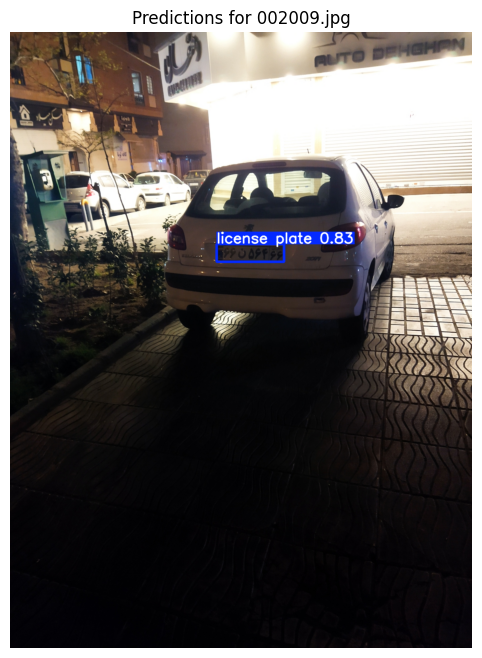


image 1/1 /kaggle/working/IR-LPD/images/004075.jpg: 640x480 1 license plate, 14.7ms
Speed: 1.9ms preprocess, 14.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


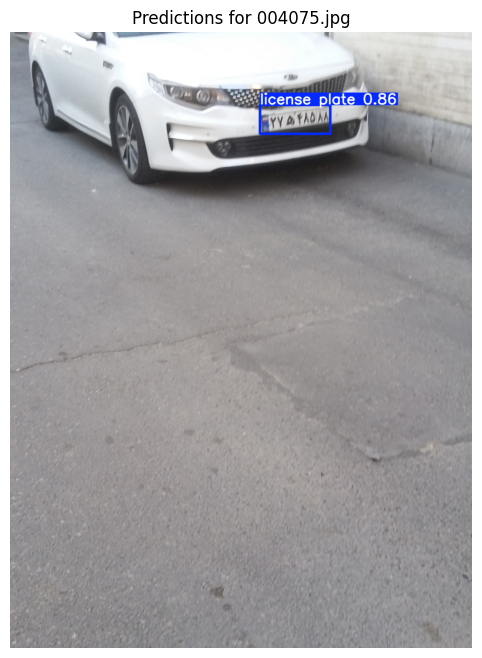


image 1/1 /kaggle/working/IR-LPD/images/000465.jpg: 640x480 1 license plate, 14.5ms
Speed: 2.3ms preprocess, 14.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


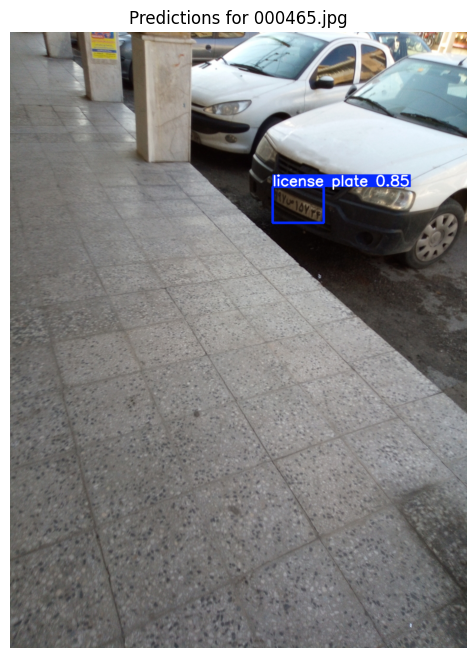


image 1/1 /kaggle/working/IR-LPD/images/000866.jpg: 480x640 1 license plate, 50.8ms
Speed: 1.5ms preprocess, 50.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


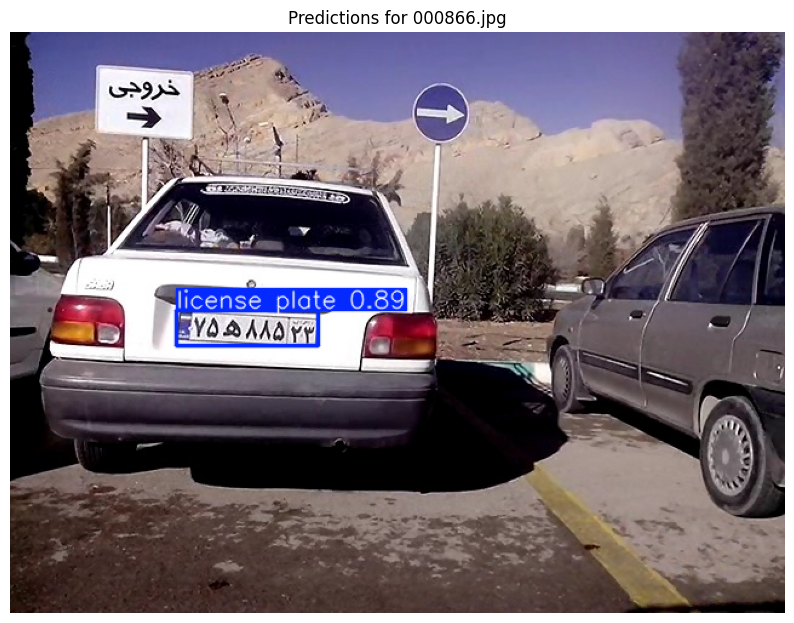


image 1/1 /kaggle/working/IR-LPD/images/003622.jpg: 480x640 2 license plates, 14.1ms
Speed: 1.8ms preprocess, 14.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


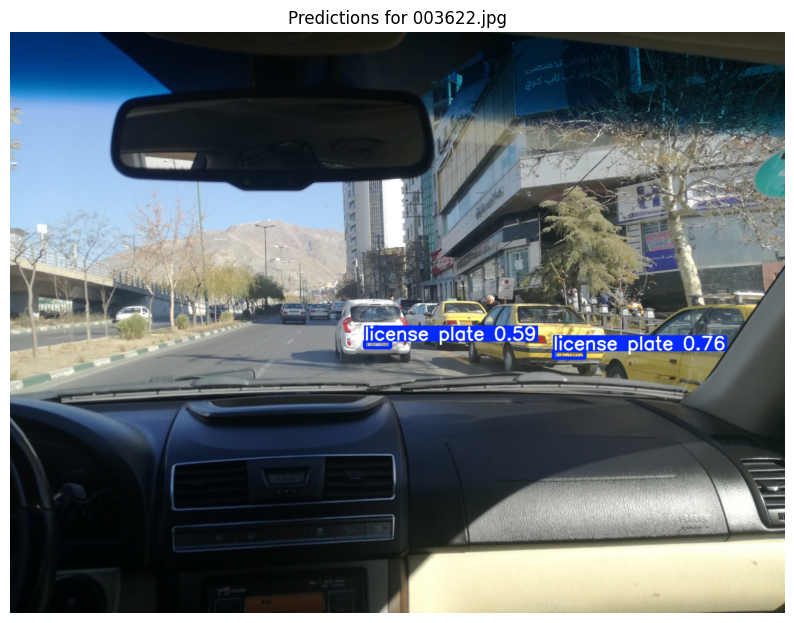

In [8]:
%matplotlib inline

print("Testing model on sample images...")
for img_file in random.sample(image_files, 5):
    img_path = os.path.join(images_dir, img_file)

    # TODO

    outputs = LPD_model.predict(source=img_path, imgsz=IMGSZ)

    plt.figure(figsize=(10, 8))

    plt.imshow(cv2.cvtColor(outputs[0].plot(), cv2.COLOR_BGR2RGB))

    plt.title(f"Predictions for {img_file}")
    plt.axis('off')
    plt.show()

### 2. LPR - CNN

In [9]:
LPR_RELATIVE_PATH = 'IR-LPR'

df = pd.read_csv(f'{BASE_PATH}/{LPR_RELATIVE_PATH}/valid_samples.csv')
df = df.sample(n=22000, random_state=42)

In [10]:
digit_vocabulary = "0123456789"
persian_letters = "آ ب پ ت ث ج چ ح خ د ذ ر ز ژ س ش ص ض ط ظ ع غ ف ق ک گ ل م ن و ه ی".split()


digit_to_idx = {char: idx for idx, char in enumerate(digit_vocabulary)}
letter_to_idx = {char: idx for idx, char in enumerate(persian_letters)}
idx_to_digit = {idx: char for idx, char in enumerate(digit_vocabulary)}
idx_to_letter = {idx: char for idx, char in enumerate(persian_letters)}


persian_to_english_digits = {
    '۰': '0', '۱': '1', '۲': '2', '۳': '3', '۴': '4',
    '۵': '5', '۶': '6', '۷': '7', '۸': '8', '۹': '9'
}

persian_letter_normalization = {
    "الف": "آ",
    "ا" : "آ",
    "ژ (معلولین و جانبازان)": "ژ",
    "ه‍" : "ه"
}



def translate(label):

    first_two_digits = ''.join([persian_to_english_digits.get(char, char) for char in label[:2]])
    persian_letter = label[2]
    remaining_digits = ''.join([persian_to_english_digits.get(char, char) for char in label[3:]])
    return first_two_digits + persian_letter + remaining_digits


def preprocess_sample(image_path, label , full_transform=True, log=False, dir_path = BASE_PATH , relative_path= f'{LPR_RELATIVE_PATH}/detections', language='en'):

    if language == 'fa' :
      label = translate(label)

    elif language != 'en':
          raise Exception('Un-supported language!')

    path = f'{dir_path}/{relative_path}'

    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

    train_transform = transforms.Compose([
        # TODO
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

    test_transform = transforms.Compose([
        # TODO
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])




    transform = train_transform if full_transform else test_transform
    image = Image.open(f'{path}/{image_path}').convert("RGB")
    image = transform(image)


    for key, value in persian_letter_normalization.items():
        label = label.replace(key, value)



    if log:
      print(label)

      for i , c in enumerate(label):
        if c in persian_letters:
          c = '*'
        print(f"{i}:{c}", end=' | ')

      print()


    digits = [digit_to_idx[char] for char in label if char.isdigit()]
    letter = letter_to_idx[label[2]]

    return image, digits, letter

In [11]:
class PLPRDataset(data.Dataset):
    def __init__(self, df , split='train',dir_path=BASE_PATH,relative_path = f'{LPR_RELATIVE_PATH}/detections', language='en'):
        self.df = df
        self.full_transform = True if split == 'train' else False
        self.dir_path = dir_path
        self.relative_path = relative_path
        self.language = language

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # TODO
        image_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label']

        image, digits, letter = preprocess_sample(image_path, label, self.full_transform, dir_path=self.dir_path, relative_path=self.relative_path, language=self.language)

        return image, torch.tensor(digits), torch.tensor(letter)

In [12]:
class FCNPLPRModel(nn.Module):
    def __init__(self, backbone_name="efficientnet_b0"):
        super(FCNPLPRModel, self).__init__()

        # TODO

        self.bb = models.__dict__[backbone_name](pretrained=True)
        self.backbone = nn.Sequential(*list(self.bb.children())[:-1])

        self.flatten = nn.Flatten()

        self.digit_fc = nn.Sequential(
            nn.Linear(self.bb.classifier[1].in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 10 * 7)
        )

        self.letter_fc = nn.Sequential(
            nn.Linear(self.bb.classifier[1].in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 32)
        )


    def forward(self, x):
        # TODO
        digit_outputs, letter_output = None, None

        x = self.backbone(x)
        x = self.flatten(x)

        digit_outputs = self.digit_fc(x).view(-1, 7, 10)

        letter_output = self.letter_fc(x)

        return digit_outputs, letter_output

In [13]:
learning_rate = 4e-4
batch_size = 32

In [14]:
dataset = PLPRDataset(df)
dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        # persistent_workers=True
)

In [15]:
LPR_model = FCNPLPRModel().to(device)
digit_criterion = nn.CrossEntropyLoss()
letter_criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 138MB/s]


In [16]:
optimizer = optim.AdamW(LPR_model.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=0.05,
    threshold_mode='rel',
    verbose=True
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [17]:
def decode_predictions(digit_outputs, letter_output):
    digit_predictions = torch.argmax(digit_outputs, dim=2)  # [batch_size, 7]
    batch_size = digit_predictions.size(0)

    digits = []
    for b in range(batch_size):  # Iterate over batch
        sample_digits = []
        for i in range(7):  # Iterate over 7 digits
            try:
                sample_digits.append(idx_to_digit[digit_predictions[b][i].item()])
            except KeyError as e:
                print(f"KeyError: {e} (digit_predictions[{b}][{i}] = {digit_predictions[b][i].item()})")
                sample_digits.append("?")  # Use a placeholder for invalid indices
        digits.append(sample_digits)

    letter_prediction = torch.argmax(letter_output, dim=1)  # [batch_size]
    letters = []
    for b in range(batch_size):
        try:
            letters.append(idx_to_letter[letter_prediction[b].item()])
        except KeyError as e:
            print(f"KeyError: {e} (letter_prediction[{b}] = {letter_prediction[b].item()})")
            letters.append("?")  # Use a placeholder for invalid indices

    labels = []
    for b in range(batch_size):
        label = "".join(digits[b][:2]) + letters[b] + "".join(digits[b][2:])
        labels.append(label)

    return labels



def evaluate_misclassification(gt, pred):
    assert len(gt) == len(pred), "GT and Pred must have the same length."

    # Collect misclassified characters
    misclassified = []
    char_error_count = 0

    for i, (gt_char, pred_char) in enumerate(zip(gt, pred)):
        if gt_char != pred_char:
            misclassified.append(f"{gt_char} with {pred_char} at pos {i}")
            char_error_count += 1

    # Format the output
    misclassified_str = " , ".join(misclassified) if misclassified else "None"
    result = (f"GT: {gt} | Pred: {pred} | "
              f"Misclassified: {misclassified_str} | "
              f"Char error count: {char_error_count}")

    return result , char_error_count





def calculate_accuracy(model, df, device, dir_path=BASE_PATH, relative_path=f'{LPR_RELATIVE_PATH}/detections', language='en', log=False , cer = False):
    model.eval()
    FP= []
    CE = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df)):
            image_path = row["image_path"]
            label = row["label"]
            try:
                image, true_digits, true_letter = preprocess_sample(image_path, label, full_transform=False, dir_path=dir_path, relative_path=relative_path, language=language)

            except Exception as e:
                print(f"Error processing {image_path}: {e}")
                continue
            true_label = "".join([digit_vocabulary[d] for d in true_digits[:2]]) \
                         + persian_letters[true_letter] \
                         + "".join([digit_vocabulary[d] for d in true_digits[2:]])
            image = image.unsqueeze(0).to(device)
            digit_outputs, letter_output = model(image)

            predicted_labels = decode_predictions(digit_outputs, letter_output)

            if predicted_labels[0] == true_label:
                correct += 1
            elif log:
                report , char_error_count = evaluate_misclassification(true_label,predicted_labels[0])
                CE += char_error_count
                FP.append(report)
            total += 1


    accuracy = correct / total * 100

    if cer:
        print(f'CER: {100* CE/(8*df.shape[0]): .4f}%')

    if log:
         for false_positive in FP:
            print(false_positive)



    return accuracy

In [18]:
full_df = pd.read_csv(f'{BASE_PATH}/IR-LPR/valid_samples.csv')
test_df = full_df.loc[~full_df.index.isin(df.index)]


In [19]:
best_accuracy = 85.0
optimal_weights = None
num_epochs = 10


for epoch in range(num_epochs):
    LPR_model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for images, digit_targets, letter_targets in progress_bar:
        images = images.to(device)
        digit_targets = digit_targets.to(device)
        letter_targets = letter_targets.to(device)

        # Forward pass
        digit_outputs, letter_output = LPR_model(images)

        digit_loss = 0
        for i in range(7):
            digit_loss += digit_criterion(digit_outputs[:, i, :], digit_targets[:, i])
        letter_loss = letter_criterion(letter_output, letter_targets)
        loss = digit_loss + letter_loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

    LPR_model.eval()
    accuracy = calculate_accuracy(
        LPR_model,
        test_df,
        device,
        relative_path= f'{LPR_RELATIVE_PATH}/detections',
        language='en'
    )
    print(f"Accuracy after Epoch {epoch+1}: {accuracy:.2f}%")

    scheduler.step(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        optimal_weights = LPR_model.state_dict()  # Save the current model weights
        print(f"New best accuracy: {best_accuracy:.2f}%. Saving model weights.")
        torch.save(LPR_model.state_dict(), f'{BASE_PATH}/PLPR-CNN.pth')

if optimal_weights is not None:
    LPR_model.load_state_dict(optimal_weights)
    print("Loaded optimal weights into the model.")

Epoch 1/10, Average Loss: 7.7353


100%|██████████| 2561/2561 [00:31<00:00, 80.52it/s]


Accuracy after Epoch 1: 77.27%


Epoch 2/10, Average Loss: 1.0016


100%|██████████| 2561/2561 [00:31<00:00, 80.25it/s]


Accuracy after Epoch 2: 88.83%
New best accuracy: 88.83%. Saving model weights.


Epoch 3/10, Average Loss: 0.6213


100%|██████████| 2561/2561 [00:31<00:00, 80.26it/s]


Accuracy after Epoch 3: 88.87%
New best accuracy: 88.87%. Saving model weights.


Epoch 4/10, Average Loss: 0.4927


100%|██████████| 2561/2561 [00:31<00:00, 80.95it/s]


Accuracy after Epoch 4: 90.36%
New best accuracy: 90.36%. Saving model weights.


Epoch 5/10, Average Loss: 0.2867


100%|██████████| 2561/2561 [00:31<00:00, 80.42it/s]


Accuracy after Epoch 5: 92.23%
New best accuracy: 92.23%. Saving model weights.


Epoch 6/10, Average Loss: 0.2334


100%|██████████| 2561/2561 [00:31<00:00, 80.88it/s]


Accuracy after Epoch 6: 91.68%


Epoch 7/10, Average Loss: 0.1930


100%|██████████| 2561/2561 [00:31<00:00, 80.76it/s]


Accuracy after Epoch 7: 91.53%


Epoch 8/10, Average Loss: 0.1325


100%|██████████| 2561/2561 [00:31<00:00, 80.24it/s]


Accuracy after Epoch 8: 92.82%
New best accuracy: 92.82%. Saving model weights.


Epoch 9/10, Average Loss: 0.1032


100%|██████████| 2561/2561 [00:31<00:00, 80.98it/s]


Accuracy after Epoch 9: 92.39%


Epoch 10/10, Average Loss: 0.0983


100%|██████████| 2561/2561 [00:31<00:00, 80.70it/s]

Accuracy after Epoch 10: 92.78%
Loaded optimal weights into the model.


In [20]:
# Calculate accuracy
accuracy = calculate_accuracy(LPR_model, test_df, device, cer=True, log=True)
print(f"Accuracy: {accuracy:.2f}%")

100%|██████████| 2561/2561 [00:31<00:00, 80.73it/s]

CER:  1.2300%
GT: 57ژ46711 | Pred: 57ع46711 | Misclassified: ژ with ع at pos 2 | Char error count: 1
GT: 81ع27744 | Pred: 81ع37744 | Misclassified: 2 with 3 at pos 3 | Char error count: 1
GT: 52ع35813 | Pred: 52ع35812 | Misclassified: 3 with 2 at pos 7 | Char error count: 1
GT: 45ت87733 | Pred: 45ت87722 | Misclassified: 3 with 2 at pos 6 , 3 with 2 at pos 7 | Char error count: 2
GT: 21ت13611 | Pred: 21ت13621 | Misclassified: 1 with 2 at pos 6 | Char error count: 1
GT: 21ت59678 | Pred: 21ت59628 | Misclassified: 7 with 2 at pos 6 | Char error count: 1
GT: 91ی36388 | Pred: 61ی36388 | Misclassified: 9 with 6 at pos 0 | Char error count: 1
GT: 16ی39933 | Pred: 16د39933 | Misclassified: ی with د at pos 2 | Char error count: 1
GT: 74ه62255 | Pred: 74ه63455 | Misclassified: 2 with 3 at pos 4 , 2 with 4 at pos 5 | Char error count: 2
GT: 87ه59611 | Pred: 87ه89611 | Misclassified: 5 with 8 at pos 3 | Char error count: 1
GT: 64ه65878 | Pred: 64ه65818 | Misclassified: 7 with 1 at pos 6 | Char erro

### 3. E2E LPDR

load the models from part 2 and 3, build a class named E2E_LPDR and plot report the metrics (accuracy and cer) for the test dataset (20% of LPD that has Splitted in section 1 ). you must also plot some samples with predicted bounding box and label too.


note that each picture might have multiple plates but in this test data for simplicity all samples just have a single plate exists in it.
plot some samples from your pipeline (predicted bb from an image + predicted label of it)


In [89]:
class E2E_LPDR:
  def __init__(self):
    self.lpd = YOLO(f"{BASE_PATH}/runs/detect/train/weights/best.pt")

    self.lpr = FCNPLPRModel().to(device)
    self.lpr.load_state_dict(torch.load(f'{BASE_PATH}/PLPR-CNN.pth'))
    self.lpr.eval()

    self.mean, self.std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

    self.plate_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=self.mean, std=self.std),
    ])

  def _eval_image(self, path):
    raw_image = Image.open(path).convert("RGB")
    np_image = cv2.cvtColor(np.array(raw_image), cv2.COLOR_RGB2BGR)

    outputs = self.lpd(np_image, verbose=False)
    if len(outputs[0]) == 0:
      return None, None, None

    first_box = outputs[0].boxes.xyxy.cpu().numpy()[0]

    plate = raw_image.crop(tuple(map(int, first_box)))
    plate = self.plate_transform(plate).unsqueeze(0).to(device)
    digit_outputs, letter_output = self.lpr(plate)
    pred = decode_predictions(digit_outputs, letter_output)

    return np_image, first_box, pred[0]

  def metrics(self, test_df):
    total, correct, cec = 0, 0, 0
    for idx, row in tqdm(test_df.iterrows(),  total=len(test_df)):
      img_path = row['image_path']
      label = row['label']
      
      # label_fa = translate(label)
      _, _, pred = self._eval_image(img_path)
      if pred is None or len(label) > len(pred):
        continue
      
      result, ce = evaluate_misclassification(label, pred)
      if ce > 6:
        continue

      total += 1
      correct += 1 if pred == label else 0
      cec += ce if pred != label else 0

    accuracy = correct / total * 100
    cer = cec / (8 * total) * 100
    print(f"Accuracy(%): {accuracy:.2f}\nCER(%): {cer:.2f}")

  def plot_images(self, test_df, num_plots=5):
    counter = 0
    for idx, row in test_df.sample(frac=1, random_state=43).iterrows():
      img_path = row['image_path']
      label = row['label']

      np_image, first_box, pred = self._eval_image(img_path)
      if np_image is None:
        continue

      result, ce = evaluate_misclassification(label, pred)
      if ce > 6:
        continue

      copy_image = np_image.copy()
      x1, y1, x2, y2 = tuple(map(int, first_box))

      plt.figure(figsize=(8, 5))

      cv2.rectangle(copy_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
      cv2.putText(copy_image, pred, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv2.LINE_AA)
      plt.imshow(cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB))
      plt.title(f"Prediction -> {label}")
      plt.axis("off")
      plt.show()

      counter += 1
      if counter >= num_plots:
        break


In [70]:
image_dir = f"{BASE_PATH}/{LPD_RELATIVE_PATH}/val/images"
image_files = sorted(os.listdir(image_dir))

labels_df = pd.read_csv(f"{BASE_PATH}/{LPD_RELATIVE_PATH}/plate_labels.csv")
label_dict = dict(zip(labels_df["image_path"], labels_df["label"]))

data = []
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)     
    label = label_dict.get(image_file, None)

    data.append((image_path, label))

df = pd.DataFrame(data, columns=["image_path", "label"])
df.head()

image_path     label
0  /kaggle/working/IR-LPD/val/images/000026.jpg  61ق46619
1  /kaggle/working/IR-LPD/val/images/000029.jpg  73ع14168
2  /kaggle/working/IR-LPD/val/images/000039.jpg  75ط68710
3  /kaggle/working/IR-LPD/val/images/000054.jpg  39ج96758
4  /kaggle/working/IR-LPD/val/images/000067.jpg  81و96244

In [90]:
e2e_lpdr = E2E_LPDR()

In [93]:
e2e_lpdr.metrics(df)

100%|██████████| 1251/1251 [00:57<00:00, 21.89it/s]

Accuracy(%): 96.09
CER(%): 0.88


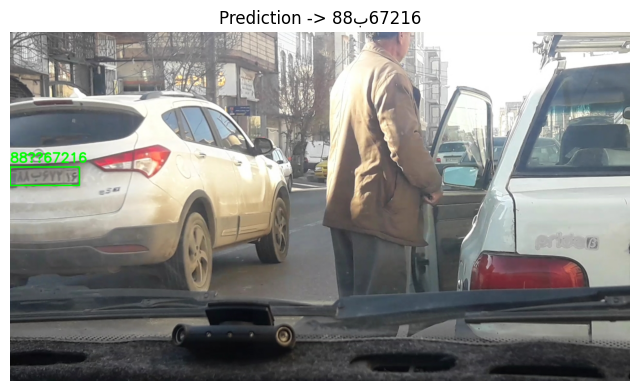

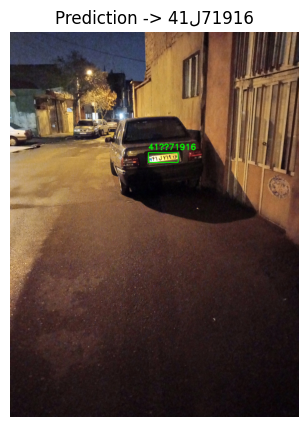

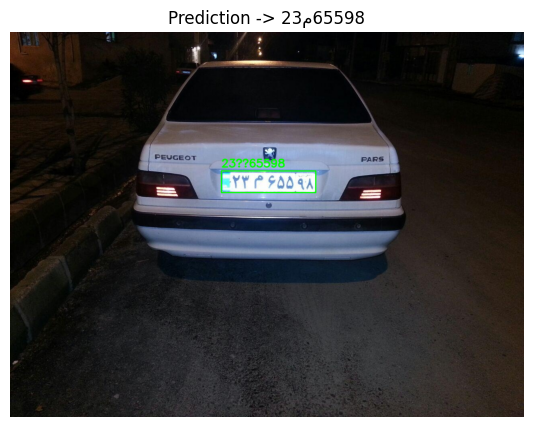

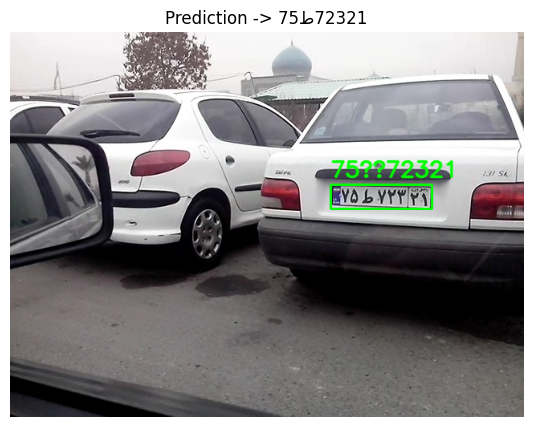

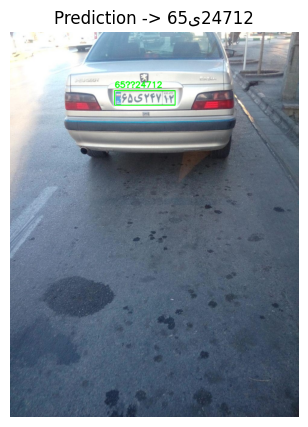

In [92]:
e2e_lpdr.plot_images(df)